# Introduction
Talkspace is an online, text-based therapy service. I have been using the service for about a year, and over that time, I've noticed it's sometimes hard for me to stay engaged. There have been long stretches of times where I have not responded to my therapist. [Patient engagement is critical to developing a therapeutic relationship](http://dx.doi.org/10.3389/fpsyg.2015.02013), so if I can increase my own responsiveness, I might increase the efficacy of my therapy.

Unfortunately, Talkspace hasn't provided me with any kind of patient engagemnt questionaire (such as the [Patient Activation Measure](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1361049/)), so I don't have any existing historical measures of enagement. The metric that is most accessible to me that I might want to optimize for is

$$
\frac{\textrm{word count of message}}{\textrm{time it takes me to write the message}}
$$

This quantity will obviously vary, and my suspicion is that some of that variability can be explained. If I can find a statistically significant factor that partly explains the variability, I'll have a lever to pull to improve my therapeutic relationship and my own mental health.

# Getting the data (you can do this too!)
Prior to this analysis, I wrote an [tool](https://github.com/vaughn-johnson/talkspace-scraper) to allow anyone to scrape his or her Talkspace message history. If you are familiar with Javascript and NPM, you can use the tool to save that data to a database or export it directly as a file.

This is obviously _highly sensitive data_. You should __never__ give your Talkspace username and password to a third party you do not trust. If you choose to use this tool, please exercise caution by [reviewing the code first](https://github.com/vaughn-johnson/talkspace-scraper). I appreciate that this stipulation might make the tool less accessible, but I strongly discourage anyone from blindly using this tool without being sure that his or her username and password will be secure.

With that being said, here I am importing my own data from my own database. If you're unfamiliar with `dotenv`, I would _highly_ encourae reading about it [here](https://pypi.org/project/python-dotenv/).

In [44]:
import pandas as pd
import numpy as np
import plotly.express as px
from pymongo import MongoClient
from dotenv import load_dotenv
from functools import reduce
import collections
from inflection import humanize
import statsmodels.api as sm
import statsmodels.graphics as sm_graphics
from patsy import dmatrices
import textstat
import re
import os

load_dotenv()
MONGO_CONNECTION_STRING = os.getenv('MONGO_CONNECTION_STRING')
pd.options.plotting.backend = "plotly"
PATIENT_NAME = 'Vaughn'

# Data Cleaning and Preparation

In [17]:
# Other message types include automated messages from Talkspace
RELEVANT_MESSAGE_TYPES = [1]

messages = pd.DataFrame([
    *MongoClient(os.getenv('MONGO_CONNECTION_STRING')).talkspace.messages.find(
        { 'message_type': { '$in': RELEVANT_MESSAGE_TYPES } }
    )
])

messages.created_at = messages.created_at.apply(pd.to_datetime)

# I tend to quote my therapist and then delimit the beginning of my own
# words using a ">"
#
# Dallas tends to begin his messages with "Vaughn,"
# and ends them with "Respectfully, Dallas"
#
# Dallas: Vaughn,
#         lorem ipsum lakdfj
#         Respectfully, Dallas
#
# Vaughn: "lorem ipsum lakdfj"
#         > abalksjfd
#
ARROW_DELIMITER = re.compile('[^-]> ')
EXTRATA = re.compile('(Vaughn,\n*|Respectfully,\n\nDallas)')
REPEAT_NEWLINES = re.compile('\n\n+')

def extract_my_words(msg):
    if not ARROW_DELIMITER.match(msg):
        return msg

    return ''.join(re.split(ARROW_DELIMITER, msg))[1:]

def process_message(msg):
    msg = extract_my_words(msg)
    msg = re.sub(EXTRATA, '', msg)
    msg = re.sub(REPEAT_NEWLINES, '\n', msg)
    return msg
                   
messages.message = messages.message.apply(process_message)

# This is critical for rest of the analysis
messages.sort_values('created_at', axis='rows', inplace=True)

# This associates consecutive messages (in time) from the same person
message_block_index = messages.user_id.ne(messages.user_id.shift()).cumsum()

message_blocks = messages.groupby(message_block_index).agg({
    'message': lambda l: '\n'.join(l),
    'created_at': min,
    'display_name': 'first'
})

message_blocks['message_length'] = message_blocks.message.apply(len)
message_blocks['question_count'] = message_blocks.message.apply(lambda x: len(re.findall(r'\?', x)))
message_blocks['word_count'] = message_blocks.message.apply(lambda x: len(re.findall(r'\s', x)) + 1)
message_blocks['readability'] = message_blocks.message.apply(textstat.flesch_reading_ease)

message_blocks = pd.concat([message_blocks, message_blocks.shift().add_prefix('prev_')], axis='columns')

# There are the quantities I'm interested in improving
message_blocks['response_time'] = (message_blocks.created_at - message_blocks.prev_created_at) / pd.Timedelta(days=1)
message_blocks['words_per_day'] = message_blocks['word_count'] / message_blocks['response_time']

# Unfortunately, any null value will interfere with the model we fit below
message_blocks.dropna(inplace=True)

You can pay no mind to the next block. It is exclusively used to make the plots appear nicer

In [18]:
### Just for aesthetics
class defaultdict(collections.defaultdict):
    def __missing__(self, key):
        if self.default_factory is None:
            raise KeyError(key)
        else:
            default_value = self[key] = self.default_factory(key)
            return default_value

LABELS = defaultdict(humanize)

## Exploration
First, let's just look at the distribution of our features. For Clarity, my name is Vaughn, and my therapist's name is Dallas.

In [19]:
px.histogram(
    message_blocks,
    x='readability',
    color='display_name',
    facet_row='display_name',
    labels=LABELS,
    template='gridon',
    title='Flesch Reading Ease Score of Messages'
)

In [20]:
px.histogram(
    message_blocks,
    x='question_count',
    color='display_name',
    facet_row='display_name',
    labels=LABELS,
    template='gridon',
    title="Number of questions asked (measured by appearence of \"?\")"
)

In [21]:
px.histogram(
    message_blocks,
    x='response_time',
    color='display_name',
    facet_row='display_name',
    labels=LABELS,
    template='gridon',
    title="Time to respond (in days)"
)

(My therapist Dallas has much shorter response times than me)

This is the quantity I'm trying to optimize for.

In [22]:
px.histogram(
    message_blocks,
    x='words_per_day',
    color='display_name',
    facet_row='display_name',
    labels=LABELS,
    template='gridon',
    title="How many words typed per days it takes to respond",
    nbins=1000,
    range_x=[0, 3 * 10**3]
)

Here are some pair-wise plots of some of the featues I've extracted above that I think might explain how I interact with my therapist

In [23]:
px.scatter_matrix(
    message_blocks,
    dimensions=[
        "words_per_day",
        "response_time",
        "prev_word_count",
        "prev_question_count",
        "prev_readability"
    ],
    opacity=0.5,
    color='display_name',
    labels=LABELS,
    title='Response data (Each point is a message, "Prev" means the previous message the point is responding to)',
    template='gridon',
    height=1000
)

Nothing incredibly interesting jumps out here. We see some normally distributed varaibles plotted against uniformly distributed variables, which of course produces a bell shape. There isn't a clear relationship anywhere. 

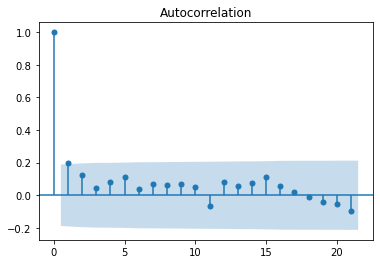

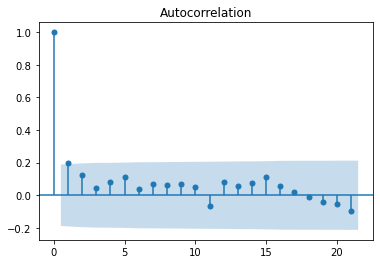

In [24]:
sm_graphics.tsaplots.plot_acf(message_blocks[message_blocks.display_name == PATIENT_NAME]['message_length'])

# Do the characteristics of my therapist's messages explain my responsiveness?

Let's try to develop a model that tries to explain my responsiveness based on the messages I'm responding to. My hypothesis is that I might take longer to respond to more complex messages. Messages with a lower readability score, which are longer, or which ask me more question. I think if these were going to have have any affect, it would probably be linear, so fitting a generalized linear model with least squares seems appropriate.

To be clear, this data is _not_ well suited for linear regression. The response variable I'm interested in does not appear to be normally distributed with any of its covariates, and the covariants aren't perfectly non-collinear. The observations are obviously not independent (though they don't seem to show any obvious autocorrelation). However, I think it's ok to give it a look.

In [33]:
# This is just setting up for some tests below
features = [
    'prev_word_count',
    'prev_question_count',
    'prev_readability',
    'prev_word_count'
]

my_messages = message_blocks[message_blocks.display_name == PATIENT_NAME]

words_per_day, X = dmatrices(f"words_per_day ~ {' + '.join(features)}",
                 data=my_messages,
                 return_type='dataframe')

response_time, X = dmatrices(f"response_time ~ {' + '.join(features)}",
                 data=my_messages,
                 return_type='dataframe')

Let's see if we can measure a meaninful difference in how many words per day I respond with

In [34]:
sm.GLS(words_per_day, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:          words_per_day   R-squared:                       0.024
Model:                            GLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8633
Date:                Wed, 11 Nov 2020   Prob (F-statistic):              0.463
Time:                        22:49:05   Log-Likelihood:                -1105.6
No. Observations:                 108   AIC:                             2219.
Df Residuals:                     104   BIC:                             2230.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1211.5989   4590.840      0.264      0.792   -7892.208    1.03e+04
prev_word_count        -1.5900      2.231     -0.713      0.478      -6.014       2.834
prev_question_count  -181.9330    268.628     -0.677      0.500    -714.632     350.766
prev_readability       21.6800     64.447      0.336      0.737    -106.120     149.480
==============================================================================
Omnibus:                      186.045   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12671.806
Skew:                           7.053   Prob(JB):                         0.00
Kurtosis:                      54.156   Cond. No.                     4.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The summary of that regression _clearly_ shows a very poor fit. I feel comfortable continuing on with the hypothesis that my therapist's messages have no effect on my responses.

I'll fit and test a second model, but instead of predicting `words per day`, I'll predict how long it takes me to respond (using the same covariates).

In [35]:
sm.GLS(response_time, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:          response_time   R-squared:                       0.106
Model:                            GLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.116
Date:                Wed, 11 Nov 2020   Prob (F-statistic):            0.00839
Time:                        22:49:06   Log-Likelihood:                -306.02
No. Observations:                 108   AIC:                             620.0
Df Residuals:                     104   BIC:                             630.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9466      2.797      0.338      0.736      -4.600       6.493
prev_word_count         0.0038      0.001      2.802      0.006       0.001       0.007
prev_question_count     0.0058      0.164      0.036      0.972      -0.319       0.330
prev_readability        0.0151      0.039      0.384      0.702      -0.063       0.093
==============================================================================
Omnibus:                       37.904   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.279
Skew:                           1.462   Prob(JB):                     1.22e-16
Kurtosis:                       5.780   Cond. No.                     4.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This second model is a little more significant, and worlds apart a better fit than the previous model. It seems like the length of my therapist's previous messages might have an effect on how long it takes me to respond. The point estimate is `0.0038`, which with the units we're using, means for every additional word my therapist send me, it takes me something on the order of 5 and a half minutes longer respond.

# Results
There are two interacting conclusions from this
1. Nothing that I looked at today from my therapists messages makes me send more messages per unit time
2. The longer my therapist's messages are, the longer it takes me to respond

What this really means is that there is some _compensatory_ effect between how long it takes me to respond to my therapist, and how much I write back, and that compensatory effect washes out any measurable effect from the length of the message I'm responding to. If my therapist sends me a long message, I will generally take longer, but respond with a longer message. This actually shows up as a slight correlation between my response time and word count (`r = 0.313`)

In [40]:
my_messages['response_time'].corr(my_messages['word_count'])

0.3126439149422042

In [43]:
px.scatter(my_messages, x='response_time', y='word_count', trendline='ols', template='gridon')

# Conclusions and next steps

I have a new rule of thumb for my therapist. For every additional paragraph you send me, you can expect an additional 18 hours or so for me to respond. However, when I finally do respond, my response will generally be slightly longer.

## Next steps
I would like to build out a language model of these messages. Sometimes my therapist characterizes some of the things I send to him as good or bad, and it would be fabulous to build a model that could predict that judgement on arbitrary text.